# Codi projecte AA I: Qui cobra més de 50k?

A continuació trobareu tot el codi utilitzat per a la realització d'aquest projecte de machine learning. Està estructurat en el mateix ordre en el que hem realitzat el procés d'aprentatge de diferents models per a realitzar prediccions i en el que ho hem documentat en el document pdf.

Abans de començar, és necessari carregar les següents llibreries: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, \
                  classification_report, accuracy_score,  precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import LabelEncoder
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [133]:
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from pandas.plotting import scatter_matrix

from scipy.stats import boxcox
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture

# 1. Preprocessing

Abans de començar amb el preprocessing, és necessari llegir el nostre Dataset. En el nostre cas, el Dataset ja venia amb la partició de "training" i "test" feta, per tant, no haurem de realitzar cap partició, sinó que únicament haurem de llegir els 2 sets diferents:

In [3]:
adult_tr = pd.read_csv("adult.data", header=0, delimiter=', ', engine='python')
adult_test = pd.read_csv("adult.test", header=0, delimiter=', ', engine='python')

adult_tr.shape, adult_test.shape

((32561, 15), (16281, 15))

## 1.1. Visió general del data set

In [4]:
adult_tr[:4]

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K


Abans de prendre decisions en el preprocessing, volem tenir una visualització general de com és el nostre set. Per fer-ho primer visualitzarem les variables numèriques i posteriorment les variables categòriques:

In [5]:
adult_tr.describe()

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
count,32561.000,3.256e+04,32561.000,32561.000,32561.000,32561.000
mean,38.582,1.898e+05,10.081,1077.649,87.304,40.437
std,13.640,1.055e+05,2.573,7385.292,402.960,12.347
min,17.000,1.228e+04,1.000,0.000,0.000,1.000
25%,28.000,1.178e+05,9.000,0.000,0.000,40.000
50%,37.000,1.784e+05,10.000,0.000,0.000,40.000
75%,48.000,2.371e+05,12.000,0.000,0.000,45.000
max,90.000,1.485e+06,16.000,99999.000,4356.000,99.000


In [6]:
categorical_columns = adult_tr.select_dtypes(include=['object']).columns
adult_tr[categorical_columns].describe()

,Workclass,Education,Marital-status,Occupation,Relationship,Race,Sex,Native-country,Income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


A continuació, visualitzem com és el set de test:

In [7]:
adult_test.describe(include = "all")

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
count,16281.000,16281,1.628e+04,16281,16281.000,16281,16281,16281,16281,16281,16281.000,16281.000,16281.000,16281,16281
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K.
freq,NaN,11210,NaN,5283,NaN,7403,2032,6523,13946,10860,NaN,NaN,NaN,14662,12435
mean,38.767,NaN,1.894e+05,NaN,10.073,NaN,NaN,NaN,NaN,NaN,1081.905,87.899,40.392,NaN,NaN
std,13.849,NaN,1.057e+05,NaN,2.568,NaN,NaN,NaN,NaN,NaN,7583.936,403.105,12.479,NaN,NaN
min,17.000,NaN,1.349e+04,NaN,1.000,NaN,NaN,NaN,NaN,NaN,0.000,0.000,1.000,NaN,NaN
25%,28.000,NaN,1.167e+05,NaN,9.000,NaN,NaN,NaN,NaN,NaN,0.000,0.000,40.000,NaN,NaN
50%,37.000,NaN,1.778e+05,NaN,10.000,NaN,NaN,NaN,NaN,NaN,0.000,0.000,40.000,NaN,NaN
75%,48.000,NaN,2.384e+05,NaN,12.000,NaN,NaN,NaN,NaN,NaN,0.000,0.000,45.000,NaN,NaN


Ens crida l'atenció que en les variables Capital-gain i Capital-Loss la majoria de observacions prenen valors en  0, depenent de del nombre d'observacions que tinguin valor 0, ens plantejaríem no tenir-les en compte:

In [8]:
(adult_tr['Capital-gain'] == 0).value_counts()
(adult_tr['Capital-loss'] == 0).value_counts()

Capital-gain
True     29849
False     2712
Name: count, dtype: int64

Capital-loss
True     31042
False     1519
Name: count, dtype: int64

In [9]:
(adult_test['Capital-gain'] == 0).value_counts()
(adult_test['Capital-loss'] == 0).value_counts()

Capital-gain
True     14958
False     1323
Name: count, dtype: int64

Capital-loss
True     15518
False      763
Name: count, dtype: int64

Com imaginaven, la majoria d'observacions prenen valor 0 en aquestes dues variables. 

A continuació, grafiquem les diferents variables per veure si tenen alguna relació amb el target:

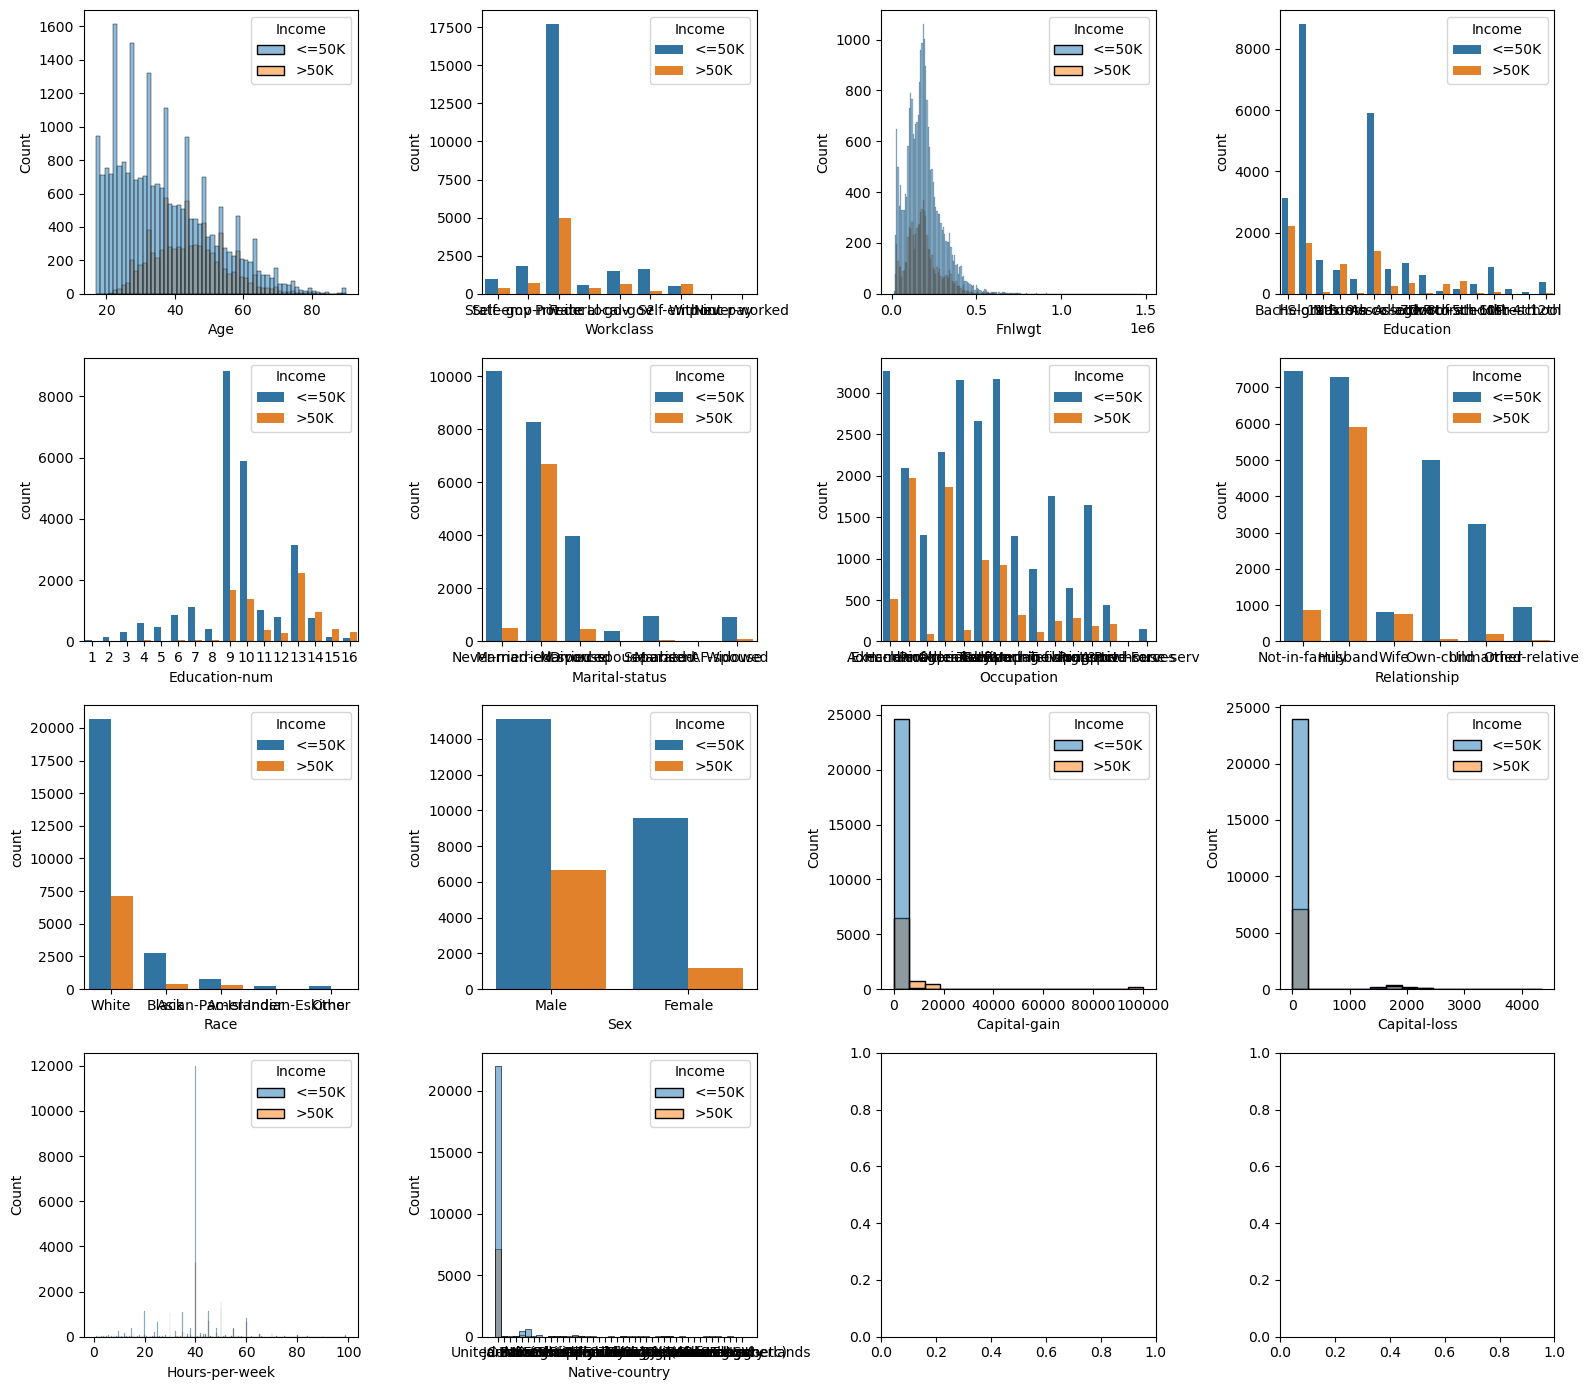

In [10]:
fig, axes = plt.subplots(4,4,figsize=(16,14));
categorical_cols = ['Workclass','Education','Education-num','Marital-status','Occupation','Relationship','Race','Sex','Native-Country']

for i, c in enumerate(adult_tr.columns[:-1]):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        a = sns.countplot(x=c,data=adult_tr, ax=ax, hue='Income');
    else: 
        sns.histplot(x=c,data=adult_tr, hue='Income',ax=ax);
plt.tight_layout();

Ens interessa tenir el plot de 4 variables en concret pel treball: 

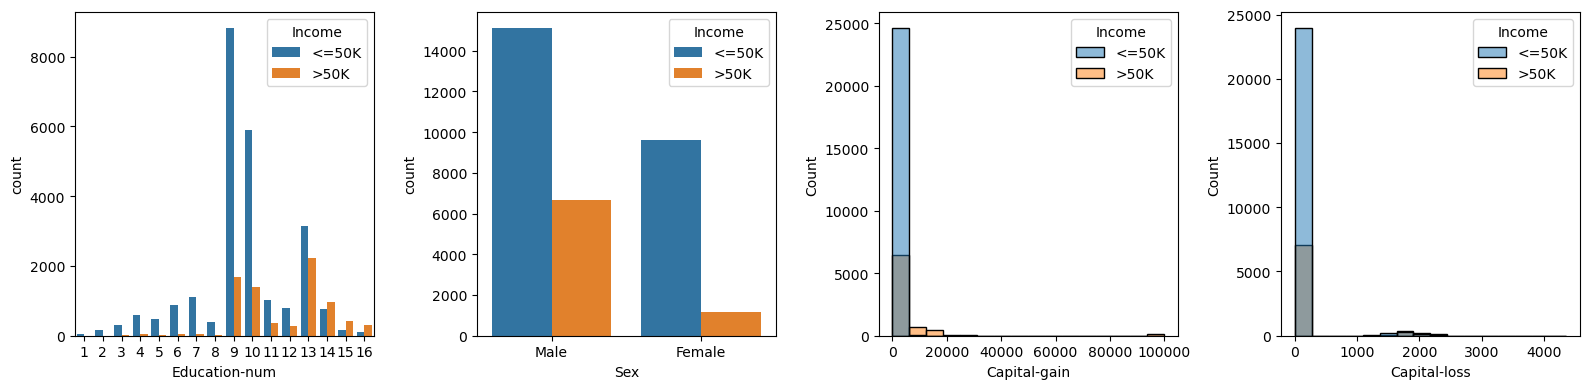

In [11]:
variablesInteres = ['Education-num', 'Sex', 'Capital-gain', 'Capital-loss']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, c in enumerate(variablesInteres):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        a = sns.countplot(x=c,data=adult_tr, ax=ax, hue='Income');
    else: 
        sns.histplot(x=c,data=adult_tr, hue='Income',ax=ax);
plt.tight_layout();

## 1.2. Feature Extraction

Creiem que ens pot ser útil crear una nova variable anomenada "Capital-difference" que sigui la diferència entre les variables "Capital-gain" i "Capital-Loss":

### 1.2.1. Training set

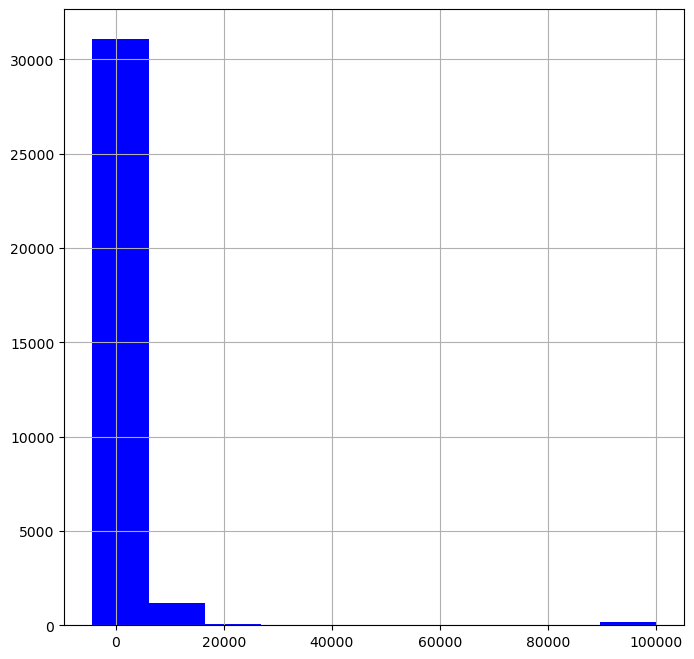

In [12]:
adult_tr['Capital-difference'] = adult_tr['Capital-gain'] - adult_tr['Capital-loss']
adult_tr['Capital-difference'].hist(figsize=(8,8), color = 'blue');

### 1.2.2. Test set

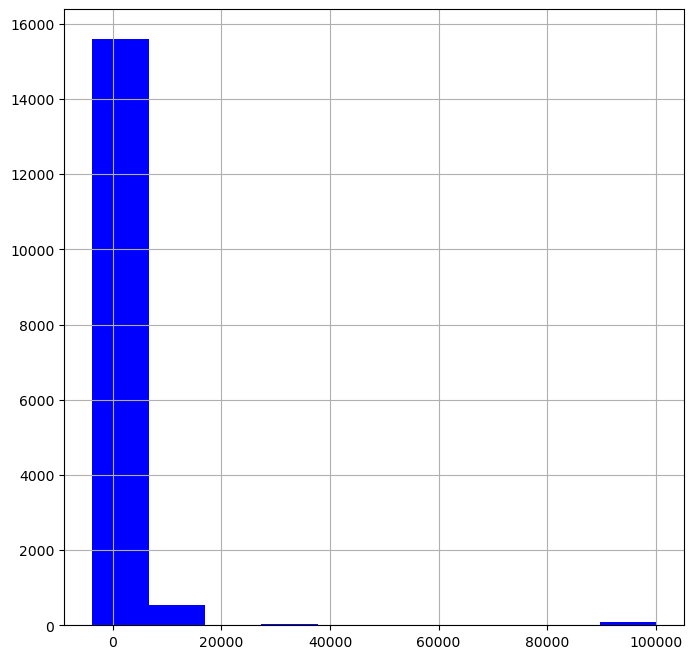

In [13]:
adult_test['Capital-difference'] = adult_test['Capital-gain'] - adult_test['Capital-loss']
adult_test['Capital-difference'].hist(figsize=(8,8), color = 'blue');

## 1.3. Feature Selection

En aquest cas, creiem convenient eliminar 3 variables. La primera de totes: "Education-num", ja que, representa exactament el mateix que la variable "Education". 

D'altra banda, també eliminarem les variables "Capital-gain" i "Capital-loss", ja que, la nova variable "Capital-difference" contè tota la informació que ens podrien proporcionar les anteriors variables.

In [14]:
adult_tr = adult_tr.drop(columns = ['Education-num', 'Capital-gain', 'Capital-loss'])
adult_test = adult_test.drop(columns = ['Education-num', 'Capital-gain', 'Capital-loss'])

Visualitzem que la creació de la nova variable i que l'eliminació de les altres 3 s'hagi dut a terme correctament pels dos sets:

In [15]:
adult_tr[:4]

,Age,Workclass,Fnlwgt,Education,Marital-status,Occupation,Relationship,Race,Sex,Hours-per-week,Native-country,Income,Capital-difference
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,2174
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,0
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,0


In [16]:
adult_test[:4]

,Age,Workclass,Fnlwgt,Education,Marital-status,Occupation,Relationship,Race,Sex,Hours-per-week,Native-country,Income,Capital-difference
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K.,0
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K.,0
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K.,0
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K.,7688


## 1.4. Detecció de missing values

Com estem fins ara en el preprocesament del dataset, primer de tot, detectarem i tractarem els missing values en el trainign set i posteriorment realitzarem la mateixa detecció i tractament pel test set.

### 1.4.1. Training set

En el nostre dataset hem detectat 2 tipus d'outliers: 
- Outliers explícits: els identifiquem perquè es representen amb el signe '?'.
- Outliers implícits: valors molt allunyats de la resta de valors que prenen la resta de mostres

Començarem per la detecció i tractament dels outliers implícits. Si visualitzem els diferents valors que prenen les nostres variables, veiem que únicament les variables amb aquest tipus de missing values són les següents: "Workclass", "Occupation" i "Native-Country".

In [17]:
adult_tr.Workclass.value_counts()
adult_tr.Occupation.value_counts()
adult_tr['Native-country'].value_counts()

Workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

Occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64

Native-country
United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France       

Com es tracten de variables categòriques no podem imputar-les. Aleshores podem esborrar les observacions amb missing values o esborrar les columnes amb missing values.  En el nostre cas, creiem que és més viable borrar les observacions, ja que les observacions amb missing values representen una part molt petita del nostre datset, a més si eliminem les variables ens quedaríem amb massa poques.

In [18]:
adult_tr.loc[adult_tr.Workclass == '?', 'Workclass'] = np.nan
adult_tr.loc[adult_tr.Occupation == '?', 'Occupation'] = np.nan
adult_tr.loc[adult_tr['Native-country'] == '?', 'Native-country'] = np.nan

adult_tr = adult_tr.dropna()
adult_tr.shape

(30162, 13)

D'altra banda, d'outliers explícits en trobem en la variable "Capital-difference", que són aquells que prenen valor 99999. Com ara es tracta d'una variable numèrica els podem imputar:

In [19]:
adult_tr['Capital-difference'][adult_tr['Capital-difference'] == 99999] = np.nan
dataSubset = adult_tr[['Age', 'Fnlwgt', 'Hours-per-week']]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11172\2534171702.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adult_tr['Capital-difference'][adult_tr['Capital-difference'] == 99999] = np.nan


In [20]:
#Imputació Capital Difference
adult_tr['Capital-difference'][adult_tr['Capital-difference'] == 99999] = np.nan
dataSubset = adult_tr[['Age', 'Fnlwgt', 'Hours-per-week']]

cleanRows = adult_tr['Capital-difference'].notna()
cleanData = dataSubset[cleanRows]
cleanData.shape

dataCapitalMissing = dataSubset[adult_tr['Capital-difference'].isna()]
dataCapitalMissing.shape

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(cleanData, adult_tr['Capital-difference'][cleanRows])
knn_inc = knn.predict(dataCapitalMissing);

Observant l'histograma de la variable "Capital-difference" podem veure com els valors corresponents a 99999 s'han imputat correctament perquè ja no hi són.

<Axes: >

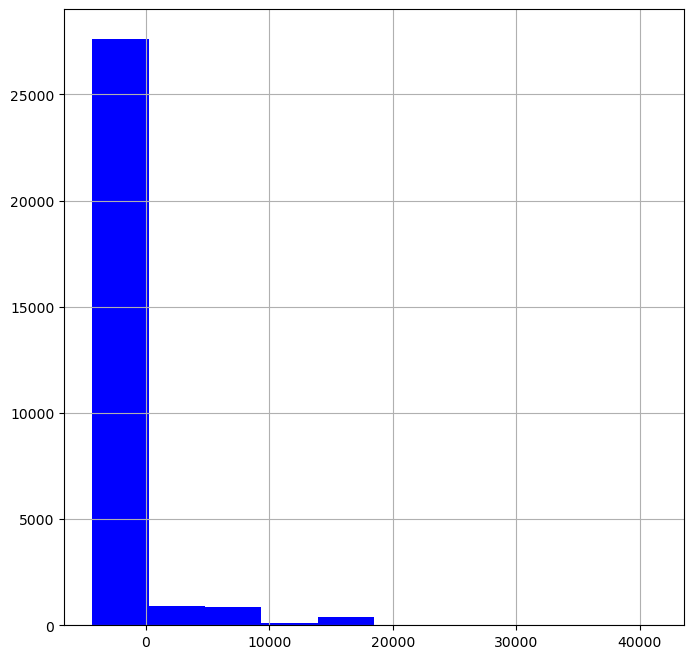

In [21]:
adult_tr['Capital-difference'].hist(figsize=(8,8), color='blue')

### 1.4.2. Test set

Pel set de test, realitzarem les mateixes transformacions que pel training set. Primer tractem els outliers implícits que apareixen en les mateixes variables que abans:

In [22]:
adult_test.Workclass.value_counts()
adult_test.Occupation.value_counts()
adult_test['Native-country'].value_counts()

adult_test.loc[adult_test.Workclass == '?', 'Workclass'] = np.nan
adult_test.loc[adult_test.Occupation == '?', 'Occupation'] = np.nan
adult_test.loc[adult_test['Native-country'] == '?', 'Native-country'] = np.nan

adult_test = adult_test.dropna()
adult_test.shape

Workclass
Private             11210
Self-emp-not-inc     1321
Local-gov            1043
?                     963
State-gov             683
Self-emp-inc          579
Federal-gov           472
Without-pay             7
Never-worked            3
Name: count, dtype: int64

Occupation
Prof-specialty       2032
Exec-managerial      2020
Craft-repair         2013
Sales                1854
Adm-clerical         1841
Other-service        1628
Machine-op-inspct    1020
?                     966
Transport-moving      758
Handlers-cleaners     702
Tech-support          518
Farming-fishing       496
Protective-serv       334
Priv-house-serv        93
Armed-Forces            6
Name: count, dtype: int64

Native-country
United-States                 14662
Mexico                          308
?                               274
Philippines                      97
Puerto-Rico                      70
Germany                          69
Canada                           61
India                            51
El-Salvador                      49
China                            47
Cuba                             43
England                          37
South                            35
Dominican-Republic               33
Italy                            32
Haiti                            31
Portugal                         30
Japan                            30
Poland                           27
Columbia                         26
Jamaica                          25
Guatemala                        24
Greece                           20
Vietnam                          19
Ecuador                          17
Iran                             16
Peru                             15
Nicaragua    

(15060, 13)

Seguidament, tractem els outliers expícits:

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11172\189747497.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adult_test['Capital-difference'][adult_test['Capital-difference'] == 99999] = np.nan


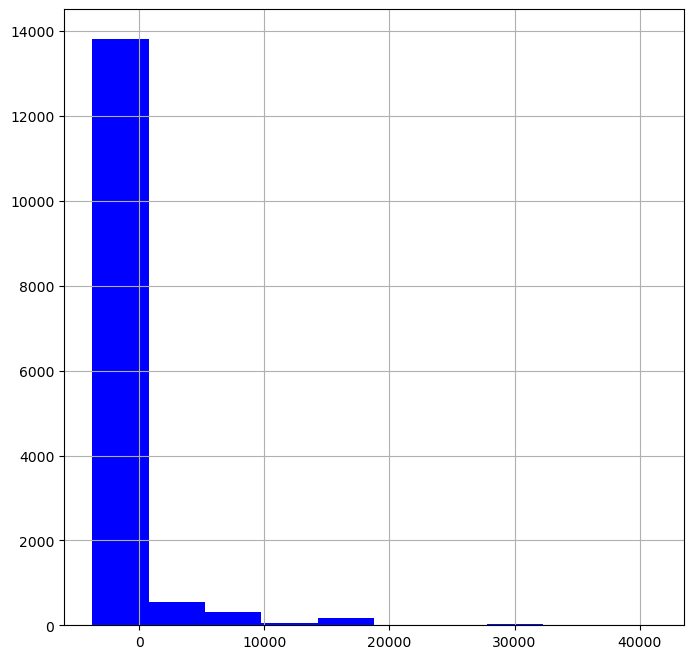

In [23]:
#Imputació Capital Difference
adult_test['Capital-difference'][adult_test['Capital-difference'] == 99999] = np.nan
dataSubset = adult_test[['Age', 'Fnlwgt', 'Hours-per-week']]

cleanRows = adult_test['Capital-difference'].notna()
cleanData = dataSubset[cleanRows]
cleanData.shape

dataCapitalMissing = dataSubset[adult_test['Capital-difference'].isna()]
dataCapitalMissing.shape

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(cleanData, adult_test['Capital-difference'][cleanRows])
knn_inc = knn.predict(dataCapitalMissing);

adult_test['Capital-difference'].hist(figsize=(8,8), color = 'blue');

## 1.5. Tractament d'outliers

Quan hem realitzat una visiualització general del nostre dataset ens hem adonat que la variable "Hoours-per-week" presentava valors molt extranys, ja que hi havia observacions en la que ens indicava que la persona treballava 99 hores setmanals. Per tant, hem de tractar els outliers d'aquesta variable.

Novament, ho farem primer pel training set i posteriorment pel test set.

### 1.5.1. Training set

<Axes: >

array([<Axes: title={'center': 'Hours-per-week'}>], dtype=object)

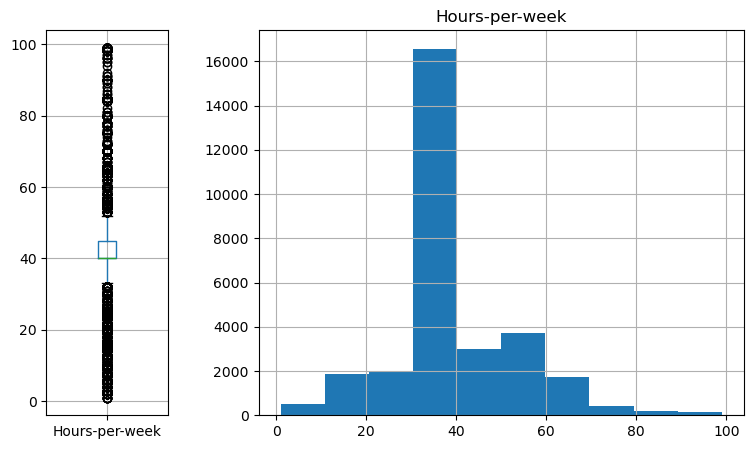

In [24]:
# Detecció Outliers Hours-per-week
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
adult_tr.boxplot(column='Hours-per-week',ax=axes[0])
adult_tr.hist(column='Hours-per-week', ax=axes[1])

In [25]:
# Tractament d'atípics d'hours-per-week
Q1 = adult_tr['Hours-per-week'].quantile(0.25)
Q3 = adult_tr['Hours-per-week'].quantile(0.75)
IQR = Q3 - Q1
Q1, Q3, IQR

# Tipus d'outliers
small_outliers = adult_tr['Hours-per-week'] < (Q1 - 1.5 * IQR)
big_outliers = adult_tr['Hours-per-week'] > (Q3 + 1.5 * IQR)
sum(small_outliers), sum(big_outliers)

(40.0, 45.0, 5.0)

(4626, 3327)

<Axes: >

array([<Axes: title={'center': 'Hours-per-week'}>], dtype=object)

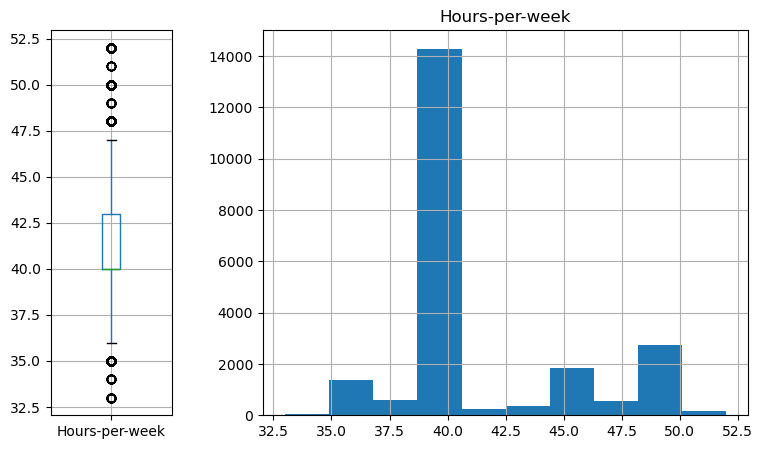

In [26]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
adult_tr[~(small_outliers | big_outliers)].boxplot(column='Hours-per-week',ax=axes[0]);
adult_tr[~(small_outliers | big_outliers)].hist(column='Hours-per-week', ax=axes[1])

Un cop detectats els outliers els passem a NA i els eliminem:

In [27]:
adult_tr.loc[adult_tr['Hours-per-week'] < (Q1 - 1.5 * IQR), 'Hours-per-week'] = np.nan
adult_tr.loc[adult_tr['Hours-per-week']  > (Q3 + 1.5 * IQR), 'Hours-per-week'] = np.nan
adult_tr = adult_tr.dropna()
adult_tr.shape

(22123, 13)

### 1.5.2. Test set 

Relitzem exactament el mateix:

<Axes: >

array([<Axes: title={'center': 'Hours-per-week'}>], dtype=object)

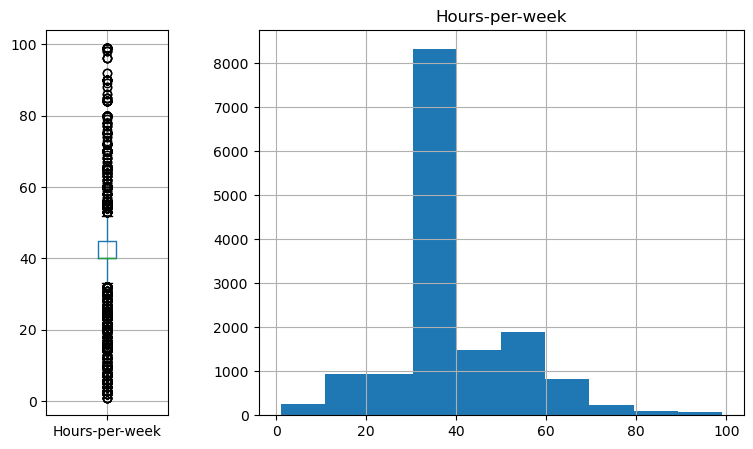

In [28]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
adult_test.boxplot(column='Hours-per-week',ax=axes[0])
adult_test.hist(column='Hours-per-week', ax=axes[1])

<Axes: >

array([<Axes: title={'center': 'Hours-per-week'}>], dtype=object)

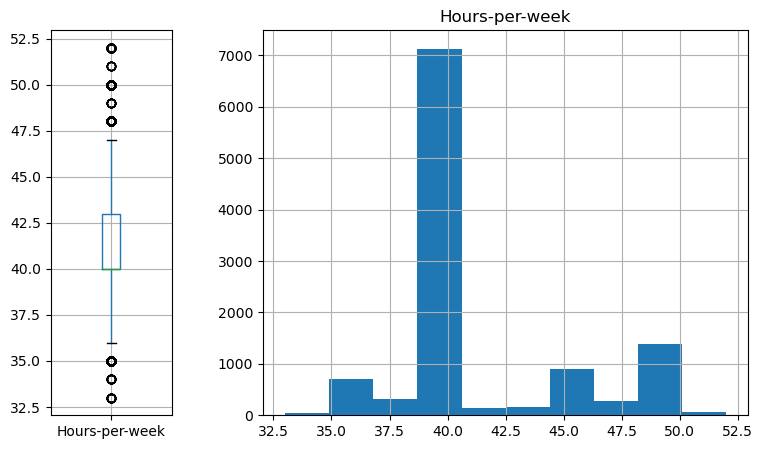

In [29]:
# Tractament d'atípics d'hours-per-week
Q1 = adult_test['Hours-per-week'].quantile(0.25)
Q3 = adult_test['Hours-per-week'].quantile(0.75)
IQR = Q3 - Q1

# Tipus d'outliers
small_outliers = adult_test['Hours-per-week'] < (Q1 - 1.5 * IQR)
big_outliers = adult_test['Hours-per-week'] > (Q3 + 1.5 * IQR)

fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
adult_test[~(small_outliers | big_outliers)].boxplot(column='Hours-per-week',ax=axes[0]);
adult_test[~(small_outliers | big_outliers)].hist(column='Hours-per-week', ax=axes[1])

In [30]:
adult_test.loc[adult_test['Hours-per-week'] < (Q1 - 1.5 * IQR), 'Hours-per-week'] = np.nan
adult_test.loc[adult_test['Hours-per-week']  > (Q3 + 1.5 * IQR), 'Hours-per-week'] = np.nan
adult_test = adult_test.dropna()
adult_test.shape

(11068, 13)

Tornem a fer una visualització general del nostre dataset per comprovar que hem solucionat el problema de valors atípics en aquesta variable:

In [31]:
adult_tr.describe(include = "all")

,Age,Workclass,Fnlwgt,Education,Marital-status,Occupation,Relationship,Race,Sex,Hours-per-week,Native-country,Income,Capital-difference
count,22123.000,22123,2.212e+04,22123,22123,22123,22123,22123,22123,22123.000,22123,22123,22123.000
unique,NaN,7,NaN,16,7,14,6,5,2,NaN,41,2,NaN
top,NaN,Private,NaN,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,NaN,United-States,<=50K,NaN
freq,NaN,16657,NaN,7612,10765,3414,9598,18878,15292,NaN,20103,16418,NaN
mean,38.806,NaN,1.915e+05,NaN,NaN,NaN,NaN,NaN,NaN,41.610,NaN,NaN,524.355
std,12.077,NaN,1.055e+05,NaN,NaN,NaN,NaN,NaN,NaN,4.029,NaN,NaN,2578.432
min,17.000,NaN,1.488e+04,NaN,NaN,NaN,NaN,NaN,NaN,33.000,NaN,NaN,-3900.000
25%,29.000,NaN,1.191e+05,NaN,NaN,NaN,NaN,NaN,NaN,40.000,NaN,NaN,0.000
50%,38.000,NaN,1.803e+05,NaN,NaN,NaN,NaN,NaN,NaN,40.000,NaN,NaN,0.000
75%,47.000,NaN,2.389e+05,NaN,NaN,NaN,NaN,NaN,NaN,43.000,NaN,NaN,0.000


## 1.6. Gaussianity

En aquest apartat normalitzarem aquelles variables numèriques que no es distribueixin normalment. Per fer-ho, aplicarem la transformació logarítmica que és la que ens ha funcionat millor

### 1.6.1. Training set

Primer representem les dades sense aplicar logaritme i aplicant logaritme:

<Axes: >

Text(0.5, 1.0, 'Histograma de la variable Age')

<Axes: >

Text(0.5, 1.0, 'Histograma del logaritme de la variable Age')

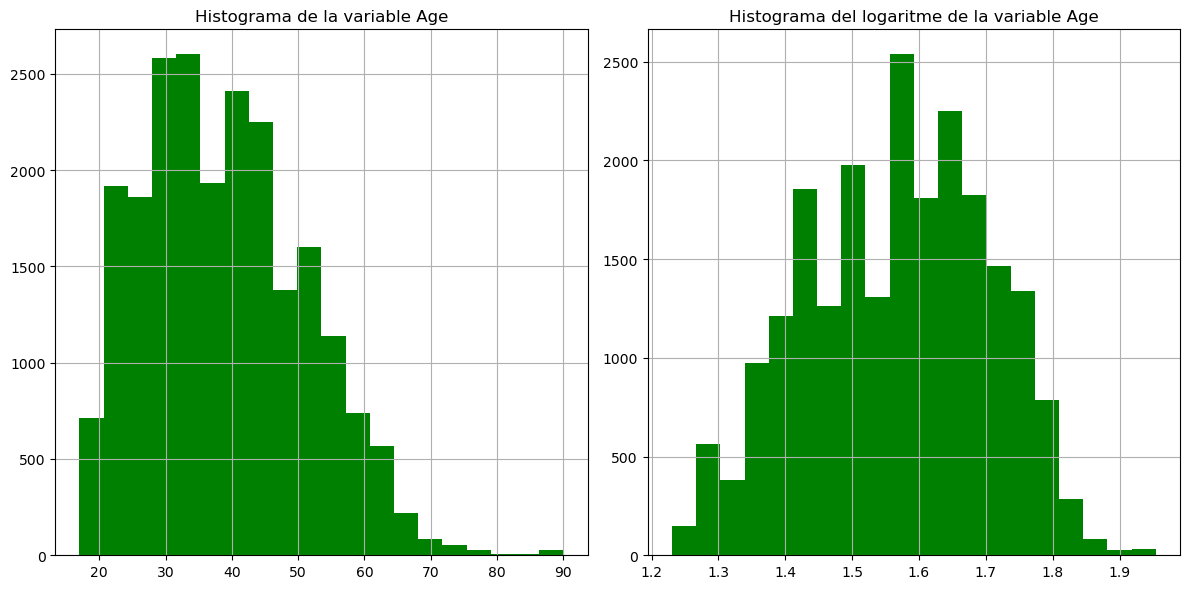

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

adult_tr.Age.hist(bins=20, ax=axes[0], color='green')
axes[0].set_title('Histograma de la variable Age')

adult_tr.Age.apply(np.log10).hist(bins=20, ax=axes[1], color='green')
axes[1].set_title('Histograma del logaritme de la variable Age')

plt.tight_layout()
plt.show()

<Axes: >

Text(0.5, 1.0, 'Histograma de la variable Fnlwgt')

<Axes: >

Text(0.5, 1.0, 'Histograma del logaritme de la variable Fnlwgt')

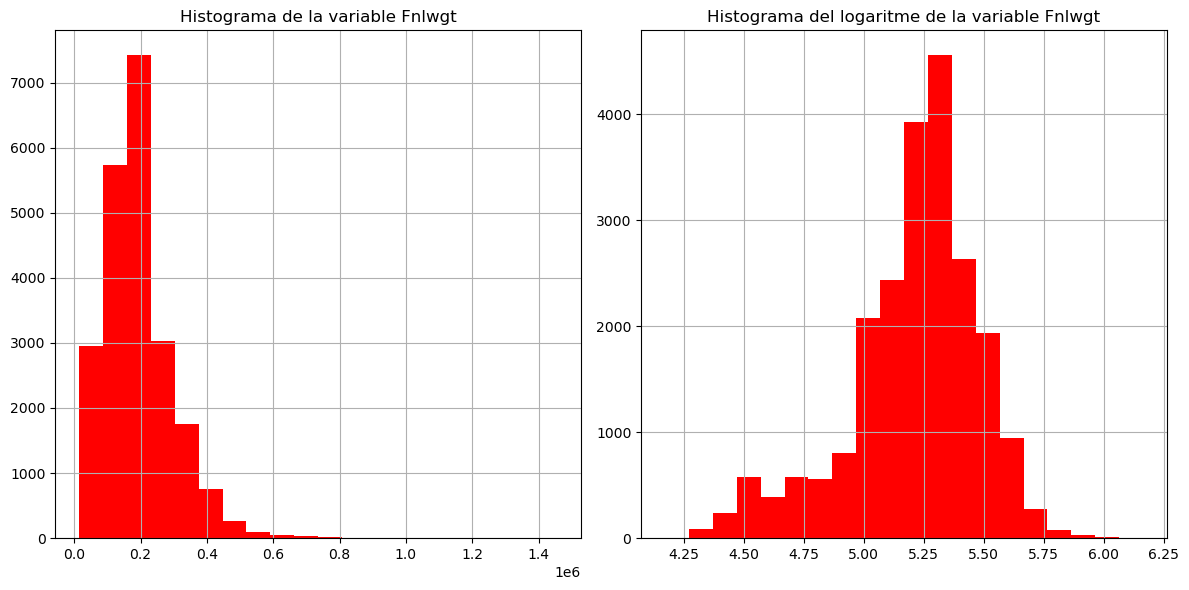

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

adult_tr.Fnlwgt.hist(bins=20, ax=axes[0], color='red')
axes[0].set_title('Histograma de la variable Fnlwgt')

adult_tr.Fnlwgt.apply(np.log10).hist(bins=20, ax=axes[1], color='red')
axes[1].set_title('Histograma del logaritme de la variable Fnlwgt')

plt.tight_layout()
plt.show()

Com veiem que si funcionen les transformacions, les apliquem en el nostre dataset:

In [34]:
adult_tr.Age = adult_tr.Age.apply(np.log10)
adult_tr.Fnlwgt = adult_tr.Fnlwgt.apply(np.log10)

### 1.6.2. Test set

<Axes: >

Text(0.5, 1.0, 'Histograma de la variable Age')

<Axes: >

Text(0.5, 1.0, 'Histograma del logaritme de la variable Age')

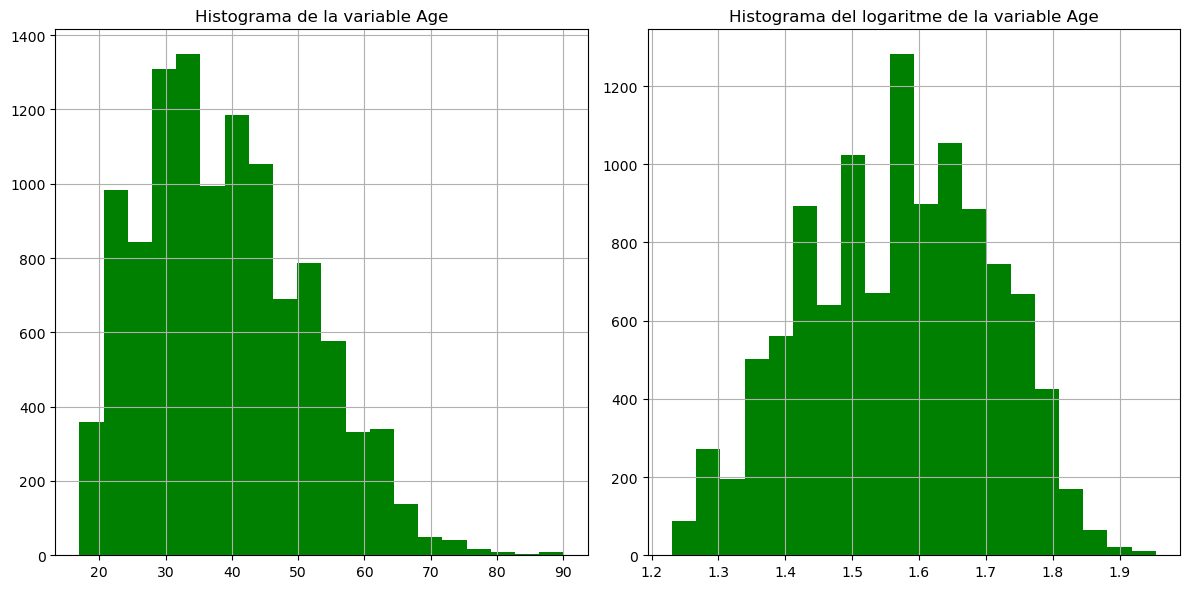

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

adult_test.Age.hist(bins=20, ax=axes[0], color='green')
axes[0].set_title('Histograma de la variable Age')

adult_test.Age.apply(np.log10).hist(bins=20, ax=axes[1], color='green')
axes[1].set_title('Histograma del logaritme de la variable Age')

plt.tight_layout()
plt.show()

<Axes: >

Text(0.5, 1.0, 'Histograma de la variable Fnlwgt')

<Axes: >

Text(0.5, 1.0, 'Histograma del logaritme de la variable Fnlwgt')

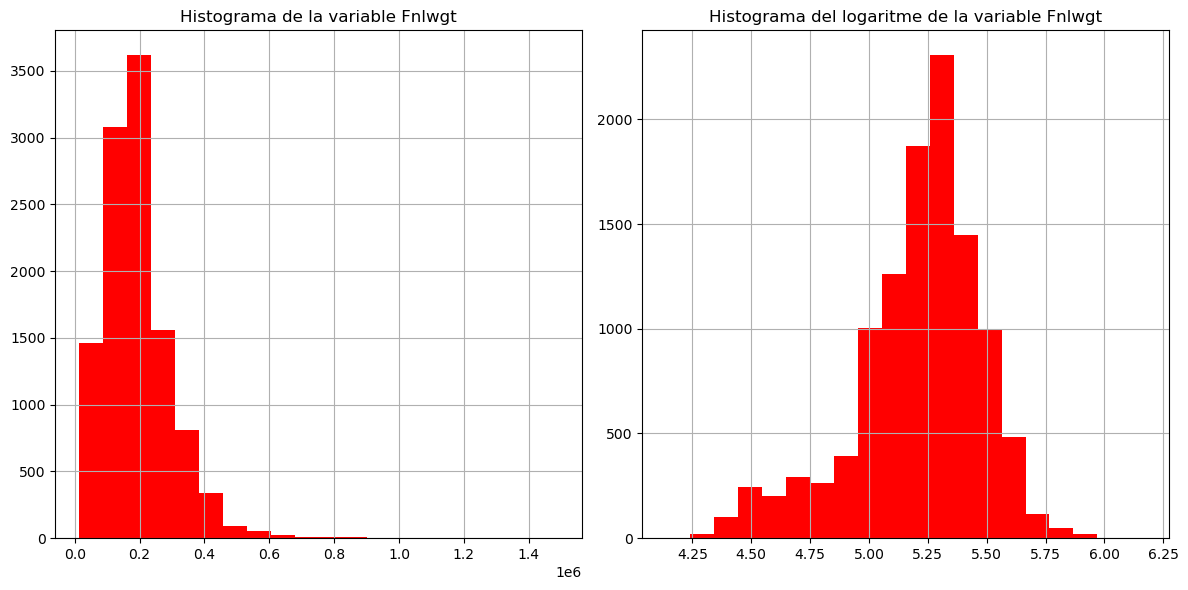

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

adult_test.Fnlwgt.hist(bins=20, ax=axes[0], color='red')
axes[0].set_title('Histograma de la variable Fnlwgt')

adult_test.Fnlwgt.apply(np.log10).hist(bins=20, ax=axes[1], color='red')
axes[1].set_title('Histograma del logaritme de la variable Fnlwgt')

plt.tight_layout()
plt.show()

In [37]:
adult_test.Age = adult_test.Age.apply(np.log10)
adult_test.Fnlwgt = adult_test.Fnlwgt.apply(np.log10)

## 1.7. Normalització de les dades

Per poder treballar amb bons models, és necessari que totes les variables estiguin en el mateix rang de valors, per tant, és necessari normalitzar.

### 1.7.1. Training set

In [38]:
min_max_scaler =  preprocessing.MinMaxScaler()
adult_tr[['Age', 'Fnlwgt', 'Hours-per-week']] = min_max_scaler.fit_transform(adult_tr[['Age', 'Fnlwgt', 'Hours-per-week']])
adult_tr[:4]

,Age,Workclass,Fnlwgt,Education,Marital-status,Occupation,Relationship,Race,Sex,Hours-per-week,Native-country,Income,Capital-difference
0,0.498,State-gov,0.360,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,0.368,United-States,<=50K,2174.0
2,0.483,Private,0.583,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.368,United-States,<=50K,0.0
3,0.682,Private,0.602,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.368,United-States,<=50K,0.0
4,0.299,Private,0.682,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.368,Cuba,<=50K,0.0


### 1.7.2. Test set

In [39]:
min_max_scaler =  preprocessing.MinMaxScaler()
adult_test[['Age', 'Fnlwgt', 'Hours-per-week']] = min_max_scaler.fit_transform(adult_test[['Age', 'Fnlwgt', 'Hours-per-week']])
adult_test[:4]

,Age,Workclass,Fnlwgt,Education,Marital-status,Occupation,Relationship,Race,Sex,Hours-per-week,Native-country,Income,Capital-difference
0,0.231,Private,0.598,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.368,United-States,<=50K.,0.0
1,0.483,Private,0.400,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.895,United-States,<=50K.,0.0
2,0.299,Local-gov,0.683,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0.368,United-States,>50K.,0.0
3,0.571,Private,0.524,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,0.368,United-States,>50K.,7688.0


## 1.8. Categorització de la variable "Capital-difference"

Si ens fixem en la normalització de les variables, podem veure que no hem aplicat sobre la variable "Capital-Difference". El motiu és que hem considerat que aquesta variable ens donarà més informació si la transformem a categórica de 3 classes:
- 1a classe: Gain ~ Capital-difference positiu
- 2a classe: Same ~ Capital-difference igual a 0
- 3a classe: Loss ~ Capital-difference negatiu

### 1.8.1 Training set

In [40]:
categorize_difference = lambda x: 'Gain' if x > 0 else ('Same' if x == 0 else 'Loss')
adult_tr['Capital-difference'] = adult_tr['Capital-difference'].apply(categorize_difference)
adult_tr['Capital-difference'].value_counts()

Capital-difference
Same    19242
Gain     1823
Loss     1058
Name: count, dtype: int64

### 1.8.2. Test set

In [41]:
adult_test['Capital-difference'] = adult_test['Capital-difference'].apply(categorize_difference)
adult_test['Capital-difference'].value_counts()

Capital-difference
Same    9631
Gain     889
Loss     548
Name: count, dtype: int64

<Axes: xlabel='Capital-difference', ylabel='count'>

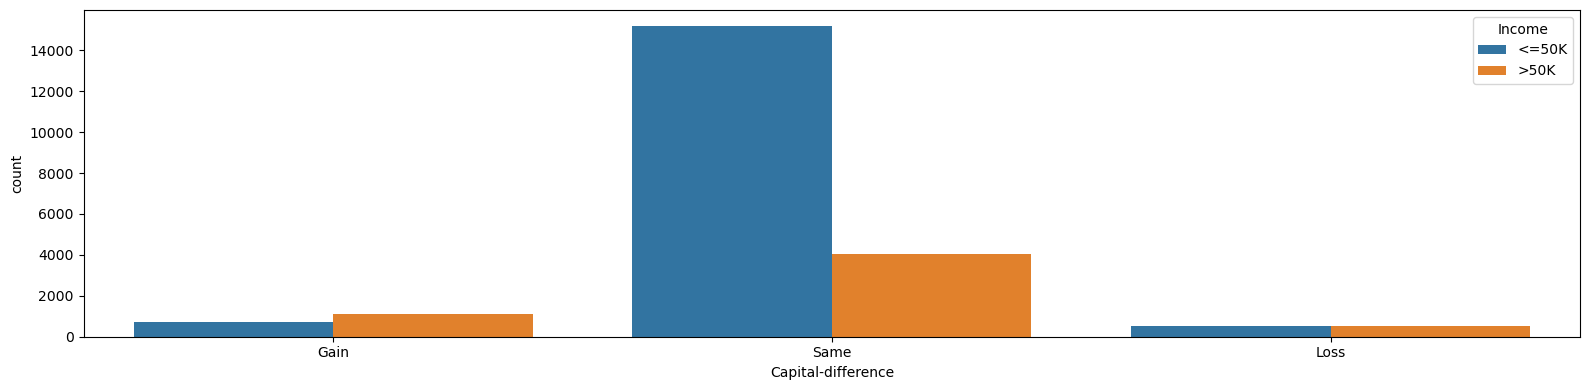

In [42]:
variablesInteres = ['Capital-difference']
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

for c in variablesInteres:
        sns.countplot(x=c, data=adult_tr, ax=ax, hue='Income')

plt.tight_layout()

# 2. Modelització

Un cop realitzat el preprocessament de les dades, comencem amb la creació de models per a fer prediccions. Cal recordar, que aquest dataset es tracta d'un dataset desbalancejat i per tant, haurem de tenir-ho en compte. 

Abans de començar amb la creació de models, és necessari crar dos sets nous de train i test aplicant "One-hot encoding", ja que per molts models serà necessari usar aquests nous sets.

## 2.1. One-hot encoding

Primer ho realitzarem pel training set:

In [43]:
CATadult_tr = adult_tr[['Workclass', 'Education', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native-country', 'Capital-difference']]
adult_tr_dummies = pd.get_dummies(CATadult_tr)
adult_tr2 = pd.concat([adult_tr.drop(columns=CATadult_tr), adult_tr_dummies], axis=1)

Ara ho realitzem pel test set:

In [44]:
CATadult_test = adult_test[['Workclass', 'Education', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native-country', 'Capital-difference']]
adult_test_dummies = pd.get_dummies(CATadult_test)
adult_test2 = pd.concat([adult_test.drop(columns=CATadult_test), adult_test_dummies], axis=1)

A continuació, transformem la categoria '>50K' a 0 i la categoria '<= 50K' a 1 per tenir tot en termes numèrics

In [45]:
adult_tr2['Income'] = adult_tr2['Income'].apply(lambda x: 1 if x == '>50K' else 0)
adult_test2['Income'] = adult_test2['Income'].apply(lambda x: 1 if x == '>50K.' else 0)

Abans de començar amb la creació de models, anem a fer un plot de les dades usan PCA:

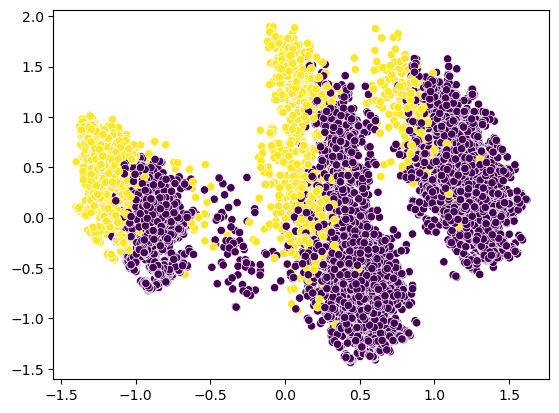

In [46]:
adult_plot = adult_tr2
label_encoder = LabelEncoder()
adult_plot['Income'] = label_encoder.fit_transform(adult_plot['Income'])

pca = PCA(n_components=2)
pca.fit(adult_plot)
coords = pca.transform(adult_plot)
sns.scatterplot(x=coords[:,0], y=coords[:,1], c=adult_plot['Income']);

Abans de començar a ajustar models i obtenir mètriques, ens hem d'assegurar que el dataset d'entrenament i el de test tinguin les mateixes columnes, és a dir, apareguin totes le categories del training al test.

In [47]:
columnes_tr2 = set(adult_tr2.columns)
columnes_test2 = set(adult_test2.columns)
columnes_uniques = columnes_tr2 - columnes_test2
print(columnes_uniques)

{'Native-country_Holand-Netherlands'}


Podem observar que l'única categoria que surt al trainig i no al test és el país d'Origen Holand-Netherlands. 

In [48]:
adult_tr2['Native-country_Holand-Netherlands'].sum()

1

A més a més, podem observar com només hi ha una observació al training amb aquest país d'origen. Perquè no doni problemes, el més fàcil és que eliminem la columna d'aquesta categoria i eliminem l'observació que té aquesta categoria. No hi ha problema en fer això perquè és una sola observació i no afecta a la nostra estructura del dataset.

In [49]:
observacio = adult_tr2[adult_tr2['Native-country_Holand-Netherlands'] == 1].index
adult_tr2 = adult_tr2.drop(observacio)
adult_tr2 = adult_tr2.drop('Native-country_Holand-Netherlands', axis=1)
adult_tr2.size

2300688

Un cop realitzat el One-hot encoding i visualitzades les observacions en un plot, definim el target i la resta de columnes tant per el dataset de train com el dataset de test.

In [50]:
X = adult_tr2.drop('Income', axis=1)
y = adult_tr2['Income']

També ens guardem la variable target del dataset de test per tal de computar les mètriques del millor model que obtinguem.

In [51]:
X_test = adult_test2.drop('Income', axis=1)
y_test = adult_test2['Income']

Afegim unes funcions que ens poden ser útils més endevant:

In [52]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

def compute_metrics(y_real,y_pred):
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [accuracy,f1_macro,precison_macro,recall_macro]

## 2.2. LDA i QDA

Per començar, amb els primers models que treballarem són amb el LDA i QDA. 

Primer de tot treballarem amb LDA:

### LDA 

In [53]:
lda_model = LinearDiscriminantAnalysis()
num_folds = 5
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_lda = cross_val_predict(lda_model, X, y, cv=kfold)
confusion(pd.Series(y), pd.Series(y_pred_lda))

predicted,0,1
target,,
0,15059,1358
1,2320,3385


In [54]:
results_train = pd.DataFrame(index=[], columns=['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [56]:
results_train.loc['LDA', :] = compute_metrics(y, y_pred_lda)
results_train

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.834,0.77,0.79,0.755


### QDA

A continuació aplicarem QDA, primer sense regularitzar i posteriorment regulariztant amb un hiperparàmetre. QDA és un mètodes molt semblant a LDA, però que no assumeix covariàncies iguals.

In [58]:
qda_model = QuadraticDiscriminantAnalysis()
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_qda = cross_val_predict(qda_model, X, y, cv=kfold)
confusion(pd.Series(y), pd.Series(y_pred_qda))

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


predicted,0,1
target,,
0,6085,10332
1,1094,4611


In [59]:
results_train.loc['QDA', :] = compute_metrics(y, y_pred_qda)
results_train

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.834,0.77,0.79,0.755
QDA,0.484,0.481,0.578,0.589


Com podem observar, QDA obtè molts mals resultats ja que hi ha molta colinealitat entre variables, és a dir, estan molt correlades i aporten informació molt similar. Per solucionar això, aplicarem RDA. 

In [61]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'reg'));
results_qda = pd.DataFrame(index=index, columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro']);

regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1];

for reg in regularization_parameters:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=reg);
    kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
    y_pred = cross_val_predict(qda_model, X, y, cv=kfold)
    results_qda.loc[('QDA',reg), :] = compute_metrics(y, y_pred);

results_qda.sort_values(by='F1 Macro', ascending=False)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaco

Accuracy F1 Macro Precision Macro Recall Macro
model reg                                                     
QDA   2.000e-01    0.798    0.758           0.745        0.785
      1.000e-01    0.772    0.743           0.734        0.795
      5.000e-01    0.817    0.742           0.769        0.725
      1.000e-02    0.737    0.713           0.717        0.781
      7.500e-01    0.801    0.668           0.787        0.646
      1.000e-03    0.671    0.655           0.684         0.74
      1.000e-04    0.619    0.609           0.665         0.71
      1.000e+00    0.767    0.529           0.824        0.552
      0.000e+00    0.484    0.481           0.578        0.589

Com podem observar, la lambda que dona millors resultats és $\lambda = 0.2$. A més si ho comparem amb QDA sense regularitzar dona molt millors resultats. Per tant, pel mètode QDA ens quedarem amb $\lambda = 0.2$. 

In [62]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.2);
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_qda = cross_val_predict(qda_model, X, y, cv=kfold)

results_train.loc['QDA-0.2', :] = compute_metrics(y, y_pred_qda)
results_train

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.834,0.77,0.79,0.755
QDA,0.484,0.481,0.578,0.589
QDA-0.2,0.798,0.758,0.745,0.785


## 2.3. Naive Bayes

La següent famíla de models que usarem seran els models Naive Bayes. Els models Naive Bayes presenten diverses alternatives per poder treballar amb ells. Nosaltres utilitzarem els següents: 
- Gaussian Naive Bayes (amb totes les variables)
- Categorical Naive Bayes (únicament variables categòriques)
- Naive Bayes only numerical (únicament variables categòriuques)
- Combine Naive Bayes (Categorical + only numerical)
- Gaussian Naive Bayes 2 (discretitzant variables numèriques)

### Gaussian Naive Bayes

In [64]:
results_NB = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

gaussian_nb = GaussianNB()
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_gaussian_nb = cross_val_predict(gaussian_nb, X, y, cv=kfold)

results_train.loc['Gaussian Naive Bayes', :] = compute_metrics(y, y_pred_gaussian_nb)
results_NB.loc['Gaussian Naive Bayes', :] = compute_metrics(y, y_pred_gaussian_nb)
results_train

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.834,0.77,0.79,0.755
QDA,0.484,0.481,0.578,0.589
QDA-0.2,0.798,0.758,0.745,0.785
Gaussian Naive Bayes,0.497,0.497,0.643,0.645


In [65]:
results_NB

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gaussian Naive Bayes,0.497,0.497,0.643,0.645


### Categorical Naive Bayes and Naive Bayes only numerical

Primer creem 2 sets amb únicament els atributs numèrics i un altre amb els atributs categòrics:

In [66]:
X_numerical = X.select_dtypes(include=['int', 'float'])
X_categorical = X.select_dtypes(exclude=['int', 'float'])

Apliquem Categorical Naive Bayes

In [67]:
categorical_NB = CategoricalNB()
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_categorical_nb = cross_val_predict(categorical_NB, X_categorical, y, cv=kfold)

results_train.loc['Categorical Naive Bayes', :] = compute_metrics(y, y_pred_categorical_nb)
results_NB.loc['Categorical Naive Bayes', :] = compute_metrics(y, y_pred_categorical_nb)

Apliquem Gaussian Naive Bayes només amb numèriques:

In [68]:
gaussian_numericalNB = GaussianNB()
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_gaussian_numericalNB = cross_val_predict(gaussian_numericalNB, X_numerical, y, cv=kfold)

results_train.loc['Gaussian-NB-only-numerical', :] = compute_metrics(y, y_pred_gaussian_numericalNB);
results_NB.loc['Gaussian-NB-only-numerical', :] = compute_metrics(y, y_pred_gaussian_numericalNB);

### Combine Categorical Naive Bayes and Gaussian Naive Bayes only numerical

In [69]:
combined_prediction_proba= cross_val_predict(categorical_NB, X_categorical, y, cv=kfold, method='predict_proba') * cross_val_predict(gaussian_numericalNB, X_numerical, y, cv=kfold, method='predict_proba')
combined_prediction = np.argmax(combined_prediction_proba,axis=1)
results_train.loc['Combined-NB', :] = compute_metrics(y, combined_prediction);
results_NB.loc['Combined-NB', :] = compute_metrics(y, combined_prediction);

Veiem resultats:

In [70]:
results_NB

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gaussian Naive Bayes,0.497,0.497,0.643,0.645
Categorical Naive Bayes,0.755,0.722,0.714,0.767
Gaussian-NB-only-numerical,0.745,0.572,0.643,0.571
Combined-NB,0.801,0.755,0.744,0.771


In [71]:
results_train

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.834,0.77,0.79,0.755
QDA,0.484,0.481,0.578,0.589
QDA-0.2,0.798,0.758,0.745,0.785
Gaussian Naive Bayes,0.497,0.497,0.643,0.645
Categorical Naive Bayes,0.755,0.722,0.714,0.767
Gaussian-NB-only-numerical,0.745,0.572,0.643,0.571
Combined-NB,0.801,0.755,0.744,0.771


## 2.4. K-NN

El següent mètode de classificació binari que usarem és k-nn:

In [75]:
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(
    estimator=knn,
    param_grid={
        'n_neighbors': [1, 3, 5, 7, 10, 15, 20, 30, 40, 50],
        'metric': ['euclidean', 'minkowski', 'manhattan']
    },
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    refit=False
)

knn_cv.fit(X, y)
results_cv = pd.DataFrame(knn_cv.cv_results_)
cols = ['param_n_neighbors', 'param_metric',
     'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro', 
    'std_test_accuracy', 'std_test_f1_macro', 'std_test_precision_macro',
    'std_test_recall_macro'
]

results_cv[cols].sort_values(by='mean_test_f1_macro',ascending=False)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'minkowski', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 10, 15, 20, 30, 40, 50]},
             refit=False,
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

,param_n_neighbors,param_metric,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro
15,15,minkowski,0.826,0.763,0.777,0.753,0.004,0.006,0.005,0.008
5,15,euclidean,0.826,0.763,0.777,0.753,0.004,0.006,0.005,0.008
25,15,manhattan,0.826,0.762,0.776,0.752,0.005,0.008,0.006,0.010
28,40,manhattan,0.829,0.761,0.784,0.746,0.003,0.005,0.005,0.006
18,40,minkowski,0.829,0.761,0.784,0.746,0.004,0.006,0.006,0.007
8,40,euclidean,0.829,0.761,0.784,0.746,0.004,0.006,0.006,0.007
17,30,minkowski,0.828,0.760,0.782,0.745,0.005,0.007,0.007,0.007
7,30,euclidean,0.828,0.760,0.782,0.745,0.005,0.007,0.007,0.007
27,30,manhattan,0.827,0.760,0.782,0.745,0.005,0.007,0.007,0.007
29,50,manhattan,0.827,0.758,0.781,0.743,0.002,0.005,0.003,0.006


Com podem observar els millors resultats els obtenim amb 50 veïns i la distància de Minkowski, per tant, serà els paràmetres que utilitzarem:

In [76]:
knn = KNeighborsClassifier(n_neighbors=50, metric='minkowski')
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_knn = cross_val_predict(knn, X, y, cv=kfold)

results_train.loc['KNN', :] = compute_metrics(y, y_pred_knn)

## 2.5 Logisitc Regression

In [78]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'));
results_logreg = pd.DataFrame(index=index, columns= ['Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C);
    y_pred_logreg = cross_val_predict(logreg, X, y, cv=kfold)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y, y_pred_logreg);

results_logreg.sort_values(by='F1 Macro', ascending=False)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Accuracy F1 Macro Precission Macro Recall Macro
model  C                                                       
LogReg 1000.0      0.835    0.771            0.792        0.757
       1.0         0.835    0.771            0.792        0.756
       100000.0    0.835    0.771            0.791        0.756
       100.0       0.835    0.771            0.792        0.756
       10.0        0.835    0.771            0.792        0.756
       10000.0     0.835    0.771            0.791        0.756
       0.1         0.834    0.768            0.793        0.752

Podem observar que els resultats són molt semblants per qualsevol valor de regularització. Per aquest motiu, considerem que no val la pena refgularitzar i afegir cost computacional. Així doncs, no cambiaremel paràmetre C i aquest es quedarà amb el seu valor 1.0 que té per defecte.

In [79]:
logreg = LogisticRegression()
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_logreg = cross_val_predict(logreg, X, y, cv=kfold)
results_train.loc['Logreg', :] = compute_metrics(y, y_pred_logreg)
results_train

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.834,0.77,0.79,0.755
QDA,0.484,0.481,0.578,0.589
QDA-0.2,0.798,0.758,0.745,0.785
Gaussian Naive Bayes,0.497,0.497,0.643,0.645
Categorical Naive Bayes,0.755,0.722,0.714,0.767
Gaussian-NB-only-numerical,0.745,0.572,0.643,0.571
Combined-NB,0.801,0.755,0.744,0.771
KNN,0.827,0.757,0.782,0.741
Logreg,0.835,0.771,0.792,0.756


## 2.6 Decision Tree, Random Forest i Extra Trees

# Decision tree

In [81]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

model_tree = DecisionTreeClassifier()

scoring_dict = {
    'f1_mac': 'f1_macro',
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

trc_cv = trc.fit(X_train, y_train)
results_cv = pd.DataFrame(trc_cv.cv_results_)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2000 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Usuario\anaconda3\li

In [82]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_acc'
]
pd.DataFrame(trc_cv.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_acc
548,entropy,None,sqrt,5,4,0.751,0.821
777,entropy,10,None,1,3,0.745,0.822
297,gini,10,None,5,3,0.745,0.822
299,gini,10,None,5,5,0.744,0.821
296,gini,10,None,5,2,0.744,0.821


Els paràmetres que optimitzen el model Decision tree són els que surten a la primera fila de la taula anterior.

In [83]:
best_params = pd.DataFrame(trc_cv.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_tree = DecisionTreeClassifier(**best_params)
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_tree = cross_val_predict(best_tree, X, y, cv=kfold)
results_train.loc['Best Decision Tree', :] = compute_metrics(y, y_pred_tree)
results_train.sort_values(by='F1 Macro', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
QDA-0.2,0.798,0.758,0.745,0.785
KNN,0.827,0.757,0.782,0.741
Combined-NB,0.801,0.755,0.744,0.771
Best Decision Tree,0.82,0.749,0.771,0.735
Categorical Naive Bayes,0.755,0.722,0.714,0.767
Gaussian-NB-only-numerical,0.745,0.572,0.643,0.571
Gaussian Naive Bayes,0.497,0.497,0.643,0.645
QDA,0.484,0.481,0.578,0.589


### Random Forest

In [146]:
random_forest = RandomForestClassifier()

ntrees = [50, 100, 200]
max_depth = [20,None]
min_samples_split = [2,4]
min_samples_leaf = [5]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=random_forest,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

rf_cv = trc.fit(X_train, y_train)

In [147]:
scoring_cols = ['param_n_estimators', 
    'param_class_weight',
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac','mean_test_acc'
]
pd.DataFrame(rf_cv.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_n_estimators,param_class_weight,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_acc
33,50,balanced_subsample,None,5,4,0.767,0.801
20,200,balanced,None,5,2,0.765,0.800
11,200,None,None,5,4,0.765,0.836
32,200,balanced_subsample,None,5,2,0.765,0.799
18,50,balanced,None,5,2,0.765,0.799


Si ens fixem, el millor Random Forest que ens ha sortit és amb el paràmetre 'class_weigth' = balanced. Aquest paràmetre combat el desbalanceig del nostre dataset, que és perjudicial per ajustar random forest. Això es pot veure en què els 5 millors models que ens han sortit tots tenen balanceig ('balanced' o 'balanced_subsample').

In [148]:
best_params = pd.DataFrame(rf_cv.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_forest = RandomForestClassifier(**best_params)
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_forest = cross_val_predict(best_forest, X, y, cv=kfold)
results_train.loc['Best Random Forest', :] = compute_metrics(y, y_pred_forest)
results_train.sort_values(by='F1 Macro', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Best Voting 4,0.838,0.783,0.79,0.777
Gradient Boosting,0.838,0.777,0.795,0.763
Best Voting 3,0.838,0.775,0.797,0.76
Best Voting,0.837,0.775,0.795,0.76
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
Best Random Forest,0.795,0.763,0.75,0.804
Best Extra Tree,0.79,0.759,0.747,0.806
QDA-0.2,0.798,0.758,0.745,0.785
KNN,0.827,0.757,0.782,0.741


En aquest cas, el Random Forest millora les prestacions del Decision Tree

## Extra trees

In [150]:
extra_trees = ExtraTreesClassifier()

ntrees = [50, 100, 200]
max_depth = [20,None]
min_samples_split = [2,4]
min_samples_leaf = [5]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=extra_trees,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance
                   },
                   cv=5,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1)

et_cv = trc.fit(X_train, y_train)

In [151]:
scoring_cols = ['param_n_estimators', 
    'param_class_weight',
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac','mean_test_acc'
]
pd.DataFrame(et_cv.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_n_estimators,param_class_weight,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_acc
19,100,balanced,None,5,2,0.760,0.793
32,200,balanced_subsample,None,5,2,0.760,0.793
20,200,balanced,None,5,2,0.759,0.793
18,50,balanced,None,5,2,0.759,0.792
7,100,None,None,5,2,0.759,0.832


In [152]:
best_params = pd.DataFrame(et_cv.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_extra_tree = ExtraTreesClassifier(**best_params)
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_extra_tree = cross_val_predict(best_extra_tree, X, y, cv=kfold)
results_train.loc['Best Extra Tree', :] = compute_metrics(y, y_pred_extra_tree)
results_train.sort_values(by='F1 Macro', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Best Voting 4,0.838,0.783,0.79,0.777
Gradient Boosting,0.838,0.777,0.795,0.763
Best Voting 3,0.838,0.775,0.797,0.76
Best Voting,0.837,0.775,0.795,0.76
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
Best Random Forest,0.795,0.763,0.75,0.804
Best Extra Tree,0.79,0.759,0.747,0.806
QDA-0.2,0.798,0.758,0.745,0.785
KNN,0.827,0.757,0.782,0.741


## 2.7 SVM

Tal i com es comenta la treball, aquest codi model ens va tardar unes 6 hores aproximadament per acabar. Per aquest motiu, hem decidit comentar el codi perquè no es pugui executar.

In [ ]:
#svm_model = SVC()

#svm_cv = GridSearchCV(estimator=svm_model,
                               #param_grid= {
                                    #'C': [0.1, 1, 10, 100],
                                    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                    #'degree': [2, 3, 4],
                                    #'gamma': ['scale', 'auto'], 
                                    #'coef0': [0.0, 0.1, 0.5]
                                #},
                               #scoring=scoring_dict,
                               #cv=5,
                               #return_train_score=True,
                               #refit=False,
                               #n_jobs=-1)


#svm_cv.fit(X, y)
#svm_results_cv = pd.DataFrame(svm_cv.cv_results_)

In [ ]:
#scoring_cols = ['param_C', 
    #'param_kernel',
    #'param_degree', 'param_gamma', 'param_coef0',
    #'mean_test_f1_mac','mean_test_acc'
#]
#svm_results_cv.sort_values(
    #by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

In [ ]:
#best_params = pd.DataFrame(svm_cv.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
#svm = SVC(**best_params)
#kfold = KFold(n_splits=5, random_state=10, shuffle=True)
#y_pred_svm = cross_val_predict(svm, X, y, cv=kfold)
#results_train.loc['SVM', :] = compute_metrics(y, y_pred_svm)
#results_train.sort_values(by='F1 Macro', ascending=False)

## 2.8 Gradient Boosting

In [93]:
gb = GradientBoostingClassifier()

gb_cv = GridSearchCV(estimator=gb,
                     scoring=['f1_macro','accuracy'], 
                     param_grid= {
                            'n_estimators': [100, 200],
                            'learning_rate': [0.01, 0.1, 0.2],
                            'max_depth': [3, 4, 5],
                            'min_samples_split': [2, 5, 10],
                            'min_samples_leaf': [1, 2, 4],
                            'max_features': ['auto', 'sqrt', 'log2'] }
                        , 
                     return_train_score=True,
                     refit = False,
                     cv=5, n_jobs=-1)


gb_cv.fit(X_train, y_train)
gb_results_cv = pd.DataFrame(gb_cv.cv_results_)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
680 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Usuario\anaconda3\lib\

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             refit=False, return_train_score=True,
             scoring=['f1_macro', 'accuracy'])

In [94]:
scoring_cols = ['param_n_estimators', 
    'param_learning_rate',
    'param_max_depth', 
    'param_max_features', 
    'mean_test_f1_macro','mean_test_accuracy'
]

gb_results_cv.sort_values(
    by='mean_test_f1_macro', ascending=False)[scoring_cols].head()

,param_n_estimators,param_learning_rate,param_max_depth,param_max_features,mean_test_f1_macro,mean_test_accuracy
289,200,0.1,5,sqrt,0.782,0.844
397,200,0.2,4,sqrt,0.782,0.843
299,200,0.1,5,sqrt,0.782,0.844
303,200,0.1,5,sqrt,0.781,0.844
407,200,0.2,4,sqrt,0.781,0.843


In [95]:
best_params = pd.DataFrame(gb_cv.cv_results_).sort_values(by='mean_test_f1_macro',ascending=False)[['params']].iloc[0,0]
gradient_boosting = GradientBoostingClassifier(**best_params)
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
y_pred_gb = cross_val_predict(gradient_boosting, X, y, cv=kfold)
results_train.loc['Gradient Boosting', :] = compute_metrics(y, y_pred_gb)
results_train.sort_values(by='F1 Macro', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gradient Boosting,0.838,0.777,0.795,0.763
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
Best Random Forest,0.796,0.764,0.751,0.806
Best Extra Tree,0.79,0.759,0.747,0.806
QDA-0.2,0.798,0.758,0.745,0.785
KNN,0.827,0.757,0.782,0.741
Combined-NB,0.801,0.755,0.744,0.771
Best Decision Tree,0.82,0.749,0.771,0.735
Categorical Naive Bayes,0.755,0.722,0.714,0.767


## 2.9 Clustering

In [116]:
kmeans = KMeans(n_clusters=3, max_iter=100)
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
y_pred_KMeans = cross_val_predict(kmeans, X, y, cv=kfold)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

In [128]:
K_values = [2,3,5,15,20]

index= pd.MultiIndex.from_arrays([['kmeans'], [3]], names=('model', 'K'))
results = pd.DataFrame(index=index, columns= ['CH score', 'Silhouette score', 'DB score'])

for k in K_values:
    kmeans = KMeans(n_clusters=k, max_iter=100)
    kmeans.fit(X, y);
    
    CH = calinski_harabasz_score(adult_tr2, kmeans.labels_ )
    S = silhouette_score(adult_tr2, kmeans.labels_ )
    DB = davies_bouldin_score(adult_tr2, kmeans.labels_ )

    results.loc[('kmeans', k),:] = [CH,S,DB]

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=100, n_clusters=2)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=100, n_clusters=3)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=100, n_clusters=5)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=100, n_clusters=15)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=100, n_clusters=20)

In [129]:
results

CH score Silhouette score DB score
model  K                                     
kmeans 3   3348.228            0.156    2.467
       2   4417.283            0.161    2.154
       5   2190.945            0.081    2.816
       15  1121.672              0.1    2.498
       20   932.152            0.097    2.459

Veiem que el millor nombre de clusters per les tres mètriques és 2 perquè té CH més gran, Silhouette més proper a 1 i DB més petit.

In [131]:
kmeans = KMeans(n_clusters=2, max_iter=100)
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
y_pred_kmeans = cross_val_predict(kmeans, X, y, cv=kfold)
print(compute_metrics(y, y_pred_kmeans))

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

[0.4614863032275563, 0.4318930961987423, 0.4681816510152123, 0.4584680530116785]


In [139]:
results_GM = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])
types = ['diag', 'full', 'spherical']

for tipe in types:
    gm = GaussianMixture(n_components=5, covariance_type='diag')
    kfold = KFold(n_splits=5, random_state=10, shuffle=True)
    y_pred_gm = cross_val_predict(gm, X, y, cv=kfold)
    results_GM.loc[tipe, :]  = compute_metrics(y, y_pred_gm)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [140]:
results_GM

,Accuracy,F1 Macro,Precision Macro,Recall Macro
diag,0.217,0.109,0.184,0.084
full,0.161,0.081,0.157,0.056
spherical,0.151,0.081,0.189,0.058


Son els pitjors valors que hem vist fins ara tant utilitzant kmeans com utilitzant Mixture of Gaussians.

In [142]:
results_train.loc['Clustering', :] = compute_metrics(y, y_pred_kmeans)
results_train.sort_values(by='F1 Macro', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Best Voting 4,0.838,0.783,0.79,0.777
Gradient Boosting,0.838,0.777,0.795,0.763
Best Voting 3,0.838,0.775,0.797,0.76
Best Voting,0.837,0.775,0.795,0.76
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
Best Random Forest,0.796,0.764,0.751,0.806
Best Extra Tree,0.79,0.759,0.747,0.806
QDA-0.2,0.798,0.758,0.745,0.785
KNN,0.827,0.757,0.782,0.741


### 2.10 Ensambles

Probem de combinar els nostres millors models per veure si la combinació dona millors resultats.

In [97]:
voting_best = VotingClassifier([('Gradient Boosting', gradient_boosting),
                                ('Logreg', logreg), ],voting='soft')
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_voting = cross_val_predict(voting_best, X, y, cv=kfold)
results_train.loc['Best Voting', :] = compute_metrics(y, y_pred_voting)
results_train.sort_values(by='F1 Macro', ascending=False)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gradient Boosting,0.838,0.777,0.795,0.763
Best Voting,0.837,0.775,0.795,0.76
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
Best Random Forest,0.796,0.764,0.751,0.806
Best Extra Tree,0.79,0.759,0.747,0.806
QDA-0.2,0.798,0.758,0.745,0.785
KNN,0.827,0.757,0.782,0.741
Combined-NB,0.801,0.755,0.744,0.771
Best Decision Tree,0.82,0.749,0.771,0.735


Fent la votació amb els dos millors models ens surten uns resultats pitjors que el millor model (Logreg-10000) i millors que el segon model (LDA)

In [154]:
voting_3best = VotingClassifier([('Gradient Boosting', gradient_boosting),
                                ('Logreg', logreg), 
                                 ('LDA', lda_model)],voting='soft')
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_voting3 = cross_val_predict(voting_3best, X, y, cv=kfold)
results_train.loc['Best Voting 3', :] = compute_metrics(y, y_pred_voting3)
results_train.sort_values(by='F1 Macro', ascending=False)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Best Voting 4,0.838,0.783,0.79,0.777
Gradient Boosting,0.838,0.777,0.795,0.763
Best Voting,0.837,0.775,0.795,0.76
Best Voting 3,0.837,0.774,0.796,0.759
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
Best Random Forest,0.795,0.763,0.75,0.804
Best Extra Tree,0.79,0.759,0.747,0.806
QDA-0.2,0.798,0.758,0.745,0.785
KNN,0.827,0.757,0.782,0.741


En canvi, si fem la votació entre els 3 millors, ens dona un millor resultat inclús que Logreg - 10000. 

In [155]:
voting_4best = VotingClassifier([('Gradient Boosting', gradient_boosting),
                                ('Logreg', logreg), 
                                ('LDA', lda_model),
                                ('Random Forest', best_forest),
                                ],voting='soft')
kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
y_pred_4best = cross_val_predict(voting_4best, X, y, cv = kfold)
results_train.loc['Best Voting 4', :] = compute_metrics(y, y_pred_4best)
results_train.sort_values(by='F1 Macro', ascending=False)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Best Voting 4,0.838,0.784,0.791,0.777
Gradient Boosting,0.838,0.777,0.795,0.763
Best Voting,0.837,0.775,0.795,0.76
Best Voting 3,0.837,0.774,0.796,0.759
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
Best Random Forest,0.795,0.763,0.75,0.804
Best Extra Tree,0.79,0.759,0.747,0.806
QDA-0.2,0.798,0.758,0.745,0.785
KNN,0.827,0.757,0.782,0.741


# 3. Resultats finals

Natejem una mica la taula final per quedar-nos amb el millor model de cada apartat.

In [111]:
results_test.rename(index = {'KNN-50-minkowski': 'KNN'}, inplace = True)

In [157]:
results_train.sort_values(by='F1 Macro', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Best Voting 4,0.838,0.784,0.791,0.777
Gradient Boosting,0.838,0.777,0.795,0.763
Best Voting,0.837,0.775,0.795,0.76
Best Voting 3,0.837,0.774,0.796,0.759
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
Best Random Forest,0.795,0.763,0.75,0.804
Best Extra Tree,0.79,0.759,0.747,0.806
QDA-0.2,0.798,0.758,0.745,0.785
KNN,0.827,0.757,0.782,0.741


In [161]:
results_train = results_train.drop('Best Voting')
results_train = results_train.drop('Best Voting 3')
results_train = results_train.drop('Best Extra Tree')
results_train = results_train.drop('Best Decision Tree')
results_train = results_train.drop('Categorical Naive Bayes')
results_train = results_train.drop('Gaussian-NB-only-numerical')
results_train = results_train.drop('Gaussian Naive Bayes')
results_train = results_train.drop('QDA')
results_train = results_train.drop('QDA-0.2')

In [162]:
results_train.sort_values(by='F1 Macro', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Best Voting 4,0.838,0.784,0.791,0.777
Gradient Boosting,0.838,0.777,0.795,0.763
Logreg,0.835,0.771,0.792,0.756
LDA,0.834,0.77,0.79,0.755
Best Random Forest,0.795,0.763,0.75,0.804
KNN,0.827,0.757,0.782,0.741
Combined-NB,0.801,0.755,0.744,0.771
Clustering,0.457,0.426,0.462,0.451


# 3.2 Càlcul estimació generalization performance

In [174]:
millor_model = pd.DataFrame(index=[], columns=['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [175]:
voting_4best = VotingClassifier([('Gradient Boosting', gradient_boosting),
                                ('Logreg', logreg), 
                                ('LDA', lda_model),
                                ('Random Forest', best_forest),
                                ],voting='soft')
voting_4best.fit(X, y)
y_pred_4best = voting_4best.predict(X_test)
millor_model.loc['Best Voting 4', :] = compute_metrics(y_test, y_pred_4best)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('Gradient Boosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         max_features='sqrt',
                                                         n_estimators=200)),
                             ('Logreg', LogisticRegression()),
                             ('LDA', LinearDiscriminantAnalysis()),
                             ('Random Forest',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     min_samples_leaf=5,
                                                     min_samples_split=4,
                                                     n_estimators=50))],
                 voting='soft')

In [176]:
millor_model

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Best Voting 4,0.837,0.78,0.787,0.773
